## VRM examples
This notebook shows example usages of the VRM sampler.

In [1]:
%matplotlib inline
from sklearn.datasets import make_blobs
import numpy as np
import vrm
import matplotlib.pyplot as plt

### SVM on blobs
In this example we illustrate the usage of VRM sampler for running SVM with hinge loss on the following dataset. 

red = negative class, green = positive class

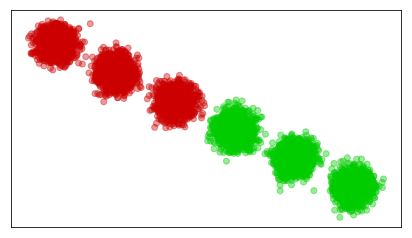

In [2]:
np.random.seed(0)


def plot(X, colors):
    fig = plt.figure(figsize=(7, 4))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.xticks([])
    plt.yticks([])

def generate_blobs(n, d):

    centers = np.zeros((d, 2))
    centers[:, 0] = [-20, -12, -4, 4, 12, 20]
    centers[:, 1] = np.arange(-12, 12, 4)[::-1]
    X, membership = make_blobs(n_samples=n, centers=centers,
                      n_features=2, random_state=0, cluster_std=1.2, shuffle=False)
    X += 100
    y = np.copy(membership)
    y[y < 3] = -1
    y[y >= 3] = 1
    X = np.hstack((X, np.ones(n).reshape(-1, 1)))
    return X, y, membership

n, d = 10000, 6
X, y, membership = generate_blobs(n, d)
colors = np.zeros((n, 4))
colors[y == 1, 1] = .8
colors[y == -1, 0] = .8
colors[:, 3] = 0.4

plot(X, colors)

Each mixture components samples a single blob uniformly at random.

In [3]:
samplers = []
for i in range(d):
    p = np.ones(n) * 1e-7
    step = n // d
    p[i * step:(i + 1) * step] = np.ones(step)
    p /= np.sum(p)
    samplers.append(vrm.Sampler(n=n, p=p, rs=np.random.RandomState(0)))
mx = vrm.VRM(n, samplers, beta=20, rs=np.random.RandomState(0), method='QP')

We can now run SGD with importance sampling using VRM.

In [4]:
w = np.zeros(3)
nr_epochs = 5
for it in range(nr_epochs * n):

    # sample a point and get its importance weight
    ind, weight = mx.sample(batch_size=1)
    ind = ind[0]
    step = 0.01 / np.sqrt(it + 1)

    if y[ind] * np.dot(w, X[ind]) < 1:
        # reweigh gradients with importance weight
        w += step * X[ind] * y[ind] * weight
        # provide feedback for the sampler
        mx.update(np.sum((X[ind] * y[ind]) ** 2))

Now we plot the blobs again, where high opacity of a blob corresponds to low mixture weight assigned to it.

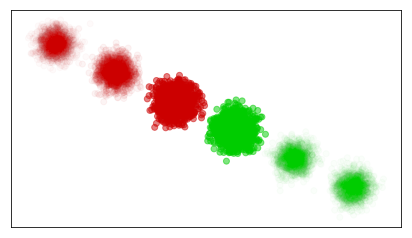

In [5]:
colors = np.zeros((n, 4))
colors[y == 1, 1] = .8
colors[y == -1, 0] = .8
colors[:, 3] = mx.w[membership] + 0.02
plot(X, colors)

### $k$-means with importance sampling
In this example we illustrate how minibatch $k$-means can benefit using the mixture sampler. For this, we extend $k$-means to support importance sampling.

In [6]:
import requests # This library is used to make requests to internet
import pandas as pd
import zipfile
from urllib.request import urlopen
from io import BytesIO
import kmeansis
import matplotlib.pyplot as plt

# get HTRU2 dataset from UCI
url = urlopen("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip")
zf = zipfile.ZipFile(BytesIO(url.read()))
df = pd.read_csv(zf.open(zipfile.ZipFile.namelist(zf)[0]), header=None)
X = df.values

# downsample dataset for speed
rs = np.random.RandomState(0)
n = 10000
X = X[rs.choice(X.shape[0], n, replace=False)]

The mixture components' sampling distributions are proportional to the square root of the distances to a randomly chosen centers combined with small uniform smoothing.

In [7]:
class SamplerKmeans:

    def __init__(self, X, center, rs):
        self.n = X.shape[0]
        self.X = X
        self.p = np.sqrt(np.sum((X - center) ** 2, axis=1))
        self.p = 0.9 * self.p / np.sum(self.p)
        self.p += 0.1 / self.n
        self.rs = rs

    def sample(self, batch_size):
        choice = rs.choice(self.n, p=self.p, size=batch_size)
        return choice, 1. / self.p[choice] / self.n

    def get_prob(self, choice):
        return self.p[choice]

    def update(self, val):
        pass


We run 25 $k$-means trials with different initialization in order to compare uniform sampling and VRM.

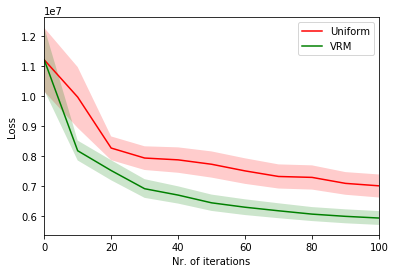

In [8]:
from sklearn.cluster.k_means_ import _init_centroids
from sklearn.utils.extmath import row_norms
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


nr_it = 25
nr_clusters = 25
km_batch_size = 5
max_iter = 101

rs = np.random.RandomState(0)
nr_samplers = 10

uniform_data = []
mx_data = []

for it in range(nr_it):
    uniform_sampler = vrm.Sampler(n, rs=rs)
    choice = X[rs.choice(n, size=nr_samplers)]
    samplers = []
    for i in range(d):
        samplers.append(SamplerKmeans(X, choice[i], rs))
    mx_sampler = vrm.VRM(n, samplers, rs=rs)

    init_centers_original = _init_centroids(X, nr_clusters, "k-means++", random_state=rs,
                                       x_squared_norms=row_norms(X, squared=True),
                                       init_size=100)
    for method, results in [(uniform_sampler, uniform_data), (mx_sampler, mx_data)]:
        init_centers = np.copy(init_centers_original)
        km = kmeansis.KmeansIS(n_clusters=nr_clusters, init=init_centers, batch_size=km_batch_size, random_state=rs,
                           max_iter=max_iter, sampler=method, init_size=1000, step_size_init=1)
        km.fit(X)
        results.append(km.log['loss'])
x_ticks = np.arange(len(uniform_data[0])) * 10
sns.tsplot(np.array(uniform_data), time=x_ticks,  color='red', condition='Uniform')
sns.tsplot(np.array(mx_data),  time=x_ticks, color='green', condition='VRM')
plt.xlabel('Nr. of iterations')
plt.ylabel('Loss')
